<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/3-classification/classification_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification Fundamentals

##Setup

In [1]:
# Common imports
import numpy as np
import os

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, precision_recall_curve, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
  plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
      rimages = images[row * images_per_row : (row + 1) * images_per_row]
      row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap = mpl.cm.binary, **options)
  plt.axis("off")

##MNIST Dataset

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them.

In [3]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it.

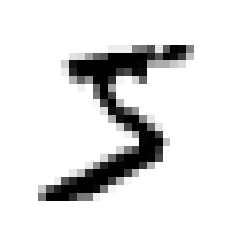

In [5]:
some_digit = X[:1]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [6]:
y[0]

'5'

Note that the label is a string.so let’s cast y to
integer:

In [7]:
y = y.astype(np.uint8)

Now, let's shows a few
more images from the MNIST dataset.

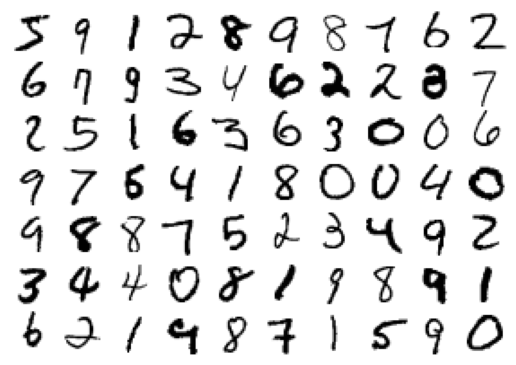

In [8]:
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [9]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

Some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. 

Shuffling the dataset ensures that this won’t happen.

In [10]:
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

##Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. 

Let’s create the target vectors for
this classification task:

In [11]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now, let's calculate total 5's and not 5's data point.

In [12]:
both_5_and_not_5 =len(y_train_5)
both_5_and_not_5

60000

In [13]:
total_not_5 = np.bitwise_not(y_train_5).sum()
total_not_5

54579

In [14]:
total_5 = both_5_and_not_5 - total_not_5
total_5

5421

In [15]:
(total_not_5 / both_5_and_not_5) * 100

90.96499999999999

In [16]:
(total_5 / both_5_and_not_5) * 100

9.035

So we have 90.96% not 5's data point and 9.03% 5's data point.In other words, we have now imbalanced dataset.

Now let’s pick a classifier and train it on this imbalanced dataset.

In [17]:
# set max_iter=5 and tol=-np.infty, to get the same results
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty ,random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

Now we can use it to detect images of the number 5:

In [18]:
sgd_clf.predict(some_digit)

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case!

##Performance Measures

###Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model,
using K-fold `cross-validation` with three folds. 

Remember that K-fold cross-validation
means splitting the training set into K folds (in this case, three), then making predictions
and evaluating them on each fold using a model trained on the remaining folds

In [19]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds?

Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [20]:
class Never5Classifier(BaseEstimator):
  def fit(self, x, y):
    pass
  def predict(self, x):
    return np.zeros((len(x), 1), dtype=bool)  

Can you guess this model’s accuracy? Let’s find out:

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

That’s right, it has over `90%` accuracy! This is simply because only about `10%` of the images are 5s, so if you always guess that an image is not a 5, you will be right about `90%` of the time.

**This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets or class imbalanced dataset** (i.e., when some classes are much more frequent than others).



###Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. 

For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

In [22]:
# To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets.
# get the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the `confusion_matrix()` function.

In [23]:
confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

The first row of this matrix considers non-5 images (the negative
class): 54,058 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 521 were wrongly classified as 5s (false positives).

The second row considers the images of 5s (the positive class): 1899 were wrongly classified as non-5s (false negatives), while the remaining 35,22 were correctly classified as 5s (true positives). 

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal(top left to bottom right):

In [24]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

###Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive pre dictions; this is called the precision of the classifier.

$$precision = \frac{TP}{TP + FP}$$

But precision is typically used
along with another metric named recall, also called sensitivity or the true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifier.

$$\frac{TP}{TP + FN}$$

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/3-classification/images/1.png?raw=1' width='800'/>

In [25]:
precision_score(y_train_5, y_train_pred)  # 3522 / (3522 + 521)

0.8711352955725946

In [26]:
3522 / (3522 + 521)

0.8711352955725946

In [27]:
recall_score(y_train_5, y_train_pred)  # 3522 / (3522 + 1899)

0.6496956281128943

In [28]:
3522 / (3522 + 1899)

0.6496956281128943

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 87.11% of the time. Moreover, it only detects 64.96% of the 5s.


It is often convenient to combine precision and recall into a single metric called the $F_1$
score, in particular if you need a simple way to compare two classifiers. The $F_1$ score is
the harmonic mean of precision and recall.

$$F_1=\frac{2}{\frac{1}{precision}+{\frac{1}{recall}}}=2*\frac{precision*recall}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}}$$





In [29]:
f1_score(y_train_5, y_train_pred)

0.7442941673710904

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection). 

On the other hand, suppose you train a classifier to detect
shoplifters in surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

###Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. 

For each instance, it computes a score based on a decision function. If
that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/3-classification/images/2.png?raw=1' width='800'/>

Conversely, lowering the threshold increases recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
`predict()` method, you can call its `decision_function()` method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [30]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([39607.23825616])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method (i.e., True). 

Let’s raise the threshold:

In [32]:
threshold = 40000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 40,000.

How do you decide which threshold to use? 

First, use the `cross_val_predict()`
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [33]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

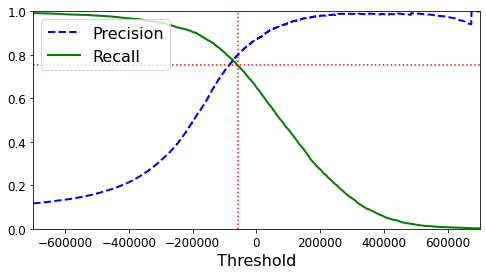

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
  threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)]

  plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
  plt.xlabel("Threshold", fontsize=16)
  plt.legend(loc="upper left", fontsize=16)
  plt.axhline(recall_80_precision, c='r', ls=':')
  plt.axvline(threshold_80_precision, c='r', ls=':')
  plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall.

Suppose you decide to aim for 90% precision. You look up the first plot and find that
you need to use a threshold of about 8,000. To be more precise you can search for the
lowest threshold that gives you at least 90% precision (`np.argmax()` will give you the
first index of the maximum value, which in this case means the first True value):

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # ~29278
threshold_90_precision

29278.01017140679

To make predictions (on the training set for now), instead of calling the classifier’s `predict()` method, you can run this code:

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let’s check these predictions’ precision and recall:

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000559910414334

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.5930640103301974

Great, you have a 90% precision classifier! 

As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and you’re done. 

But wait, not so fast. **A high-precision classifier is not very useful if its
recall is too low!**

>If someone says, “Let’s reach 99% precision,” you should ask, “At
what recall?”

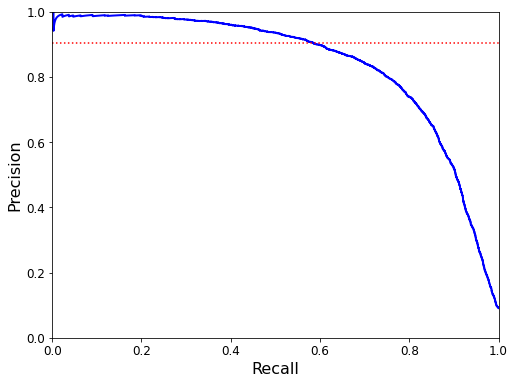

In [40]:
def plot_precision_vs_recall(precisions, recalls):
  recall_50_precision = recalls[np.argmax(precisions >= 0.50)]
  threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("Recall", fontsize=16)
  plt.ylabel("Precision", fontsize=16)
  plt.axvline(threshold_90_precision, c='r', ls=':')
  plt.axhline(recall_50_precision, c='r', ls=':')
  plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall trade-off just before that drop—for example,
at around 60% recall. But of course, the choice depends on your project.

###The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR).

The FPR is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus
1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR
and FPR for various threshold values:

In [41]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib.

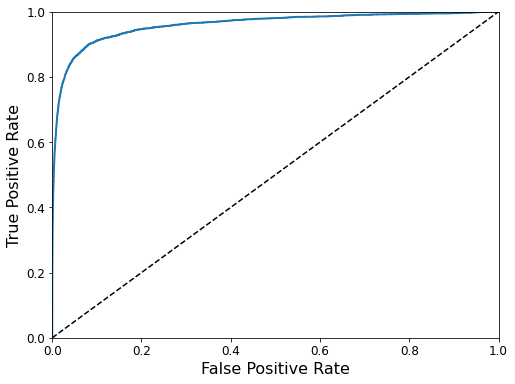

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [43]:
roc_auc_score(y_train_5, y_scores)

0.9598058535696421

>As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve.

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC
AUC score to those of the SGDClassifier.



In [44]:
forest_clf = RandomForestClassifier(random_state=42)

# predict_proba() method returns an array containing a row per instance and a column per class, 
# each containing the probability that the given instance belongs to the given class
y_probs_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

The `roc_curve()` function expects labels and scores, but instead of scores you can give it class probabilities. 

Let’s use the positive class’s probability as the score:

In [45]:
y_scores_forest = y_probs_forest[:, 1]  # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as
well to see how they compare.

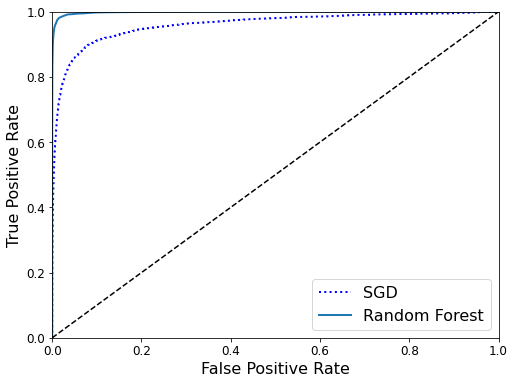

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

As you can see, the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. 

As a result, its ROC AUC score is also significantly better:

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

Try measuring the precision and recall scores: you should find 99.0% precision and
86.6% recall. Not too bad!

In [48]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [49]:
recall_score(y_train_5, y_train_pred_forest)

0.8695812580704667

You now know how to train binary classifiers, choose the appropriate metric for your
task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff
that fits your needs, and use ROC curves and ROC AUC scores to compare various
models.

##Multiclass Classificatio